In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 수집을 위한 라이브러리
import yfinance as yf

# 머신 러닝 및 딥러닝 라이브러리
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
# 노인들을 위한 안정적인 자산 리스트 
asset_list = [
    '005930.KS',   
    '000810.KS',  
    '005830.KS',   
    '018670.KS',  
    '000270.KS',   
    '000660.KS',   
    '036460.KS',   
    '373220.KS',  
    '105560.KS',  
    '267250.KS'   
]


In [5]:
# 시작일과 종료일 설정
start_date = '2010-01-01'
end_date = '2024-09-01'

# 가격 데이터 수집
price_data = yf.download(asset_list, start=start_date, end=end_date)['Adj Close']

# 결측치 처리
price_data = price_data.ffill()
price_data = price_data.ffill()

# 수익률 계산
returns = price_data.pct_change().dropna()


[*********************100%%**********************]  10 of 10 completed


In [6]:
# 노인 투자자의 위험 허용도 설정 (0에 가까울수록 보수적)
risk_tolerance = 0.2

In [7]:
# 자산별 통계적 특징 계산
features = pd.DataFrame()

# 평균 수익률
features['mean_return'] = returns.mean()

# 수익률 변동성
features['volatility'] = returns.std()

# 샤프 비율 (무위험 수익률은 0으로 가정)
features['sharpe_ratio'] = features['mean_return'] / features['volatility']

# 상관관계 행렬
correlation = returns.corr()


# 특징 데이터프레임에 추가
for asset in asset_list:
    if asset in correlation.columns:
        features.loc[asset, 'correlation_with_portfolio'] = correlation[asset].mean()
    else:
        print(f"{asset} is not in correlation columns.")


# 특징 정규화
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# 특징과 타겟 분리
X = features_scaled
y = features['mean_return'].values


In [8]:
# 학습용 및 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# 모델 구축
model = Sequential()
model.add(Input(shape=(X.shape[1],)))  # Input 레이어 추가
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # 출력층

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping 콜백 설정
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, batch_size=4,
                    validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0646 - val_loss: 0.0138
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0390 - val_loss: 3.0385e-04
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0200 - val_loss: 0.0012
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0166 - val_loss: 0.0040
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0198 - val_loss: 0.0065
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0112 - val_loss: 0.0067
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0073 - val_loss: 0.0054
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0114 - val_loss: 0.0029
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0110 - val_loss: 0.0013
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - val_loss: 8.2606e-04
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0177

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Model - MSE: 0.002180751902141622 MAE: 0.035702475270578536


C:\Users\rkddk\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


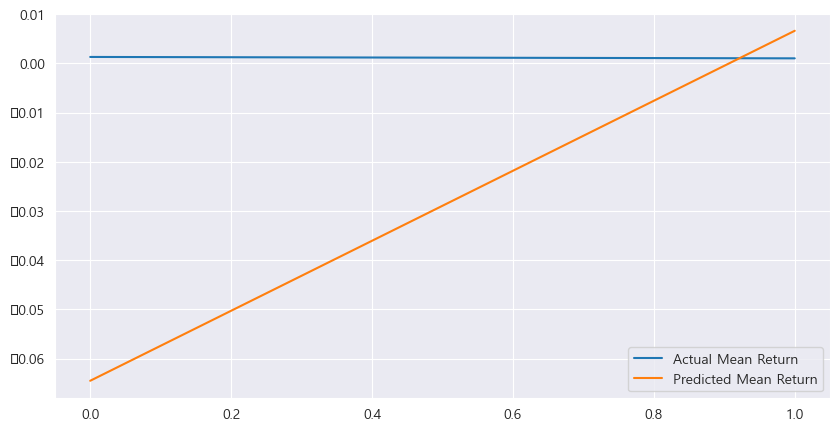

In [10]:
# 예측 수행
y_pred = model.predict(X_test)

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print('Model - MSE:', mse, 'MAE:', mae)

# 실제 값과 예측 값 비교
plt.figure(figsize=(10,5))
plt.plot(y_test, label='Actual Mean Return')
plt.plot(y_pred, label='Predicted Mean Return')
plt.legend()
plt.show()


In [11]:
# 전체 자산에 대해 예측 수행
features_scaled_all = scaler.transform(features)
predicted_returns = model.predict(features_scaled_all)

# 예측된 수익률을 데이터프레임에 추가
features['predicted_return'] = predicted_returns

# 위험 허용도에 따른 가중치 계산
features['adjusted_score'] = features['predicted_return'] / features['volatility'] * risk_tolerance

# 가중치 정규화
features['weight'] = features['adjusted_score'] / features['adjusted_score'].sum()

# 추천 포트폴리오 출력
recommended_portfolio = features[['predicted_return', 'volatility', 'weight']]
print("추천 포트폴리오 구성:")
print(recommended_portfolio.sort_values('weight', ascending=False))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
추천 포트폴리오 구성:
           predicted_return  volatility    weight
Ticker                                           
018670.KS         -0.094337    0.020711  0.676319
267250.KS         -0.064515    0.017454  0.548819
005830.KS         -0.041178    0.022686  0.269510
036460.KS         -0.024144    0.030421  0.117842
373220.KS         -0.008455    0.025885  0.048497
000810.KS         -0.004070    0.020931  0.028875
000660.KS          0.006608    0.024318 -0.040345
000270.KS          0.025399    0.019734 -0.191107
105560.KS          0.027854    0.021160 -0.195450
005930.KS          0.027454    0.015502 -0.262960


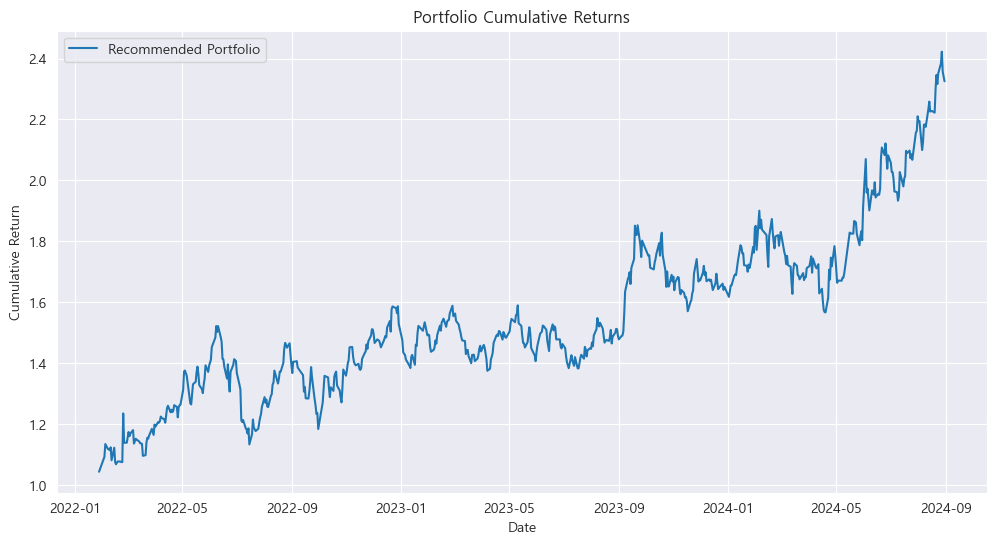

In [12]:
# 추천 포트폴리오의 일일 수익률 계산
portfolio_returns = (returns * recommended_portfolio['weight']).sum(axis=1)

# 누적 수익률 계산
cumulative_returns = (1 + portfolio_returns).cumprod()

# 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='Recommended Portfolio')
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


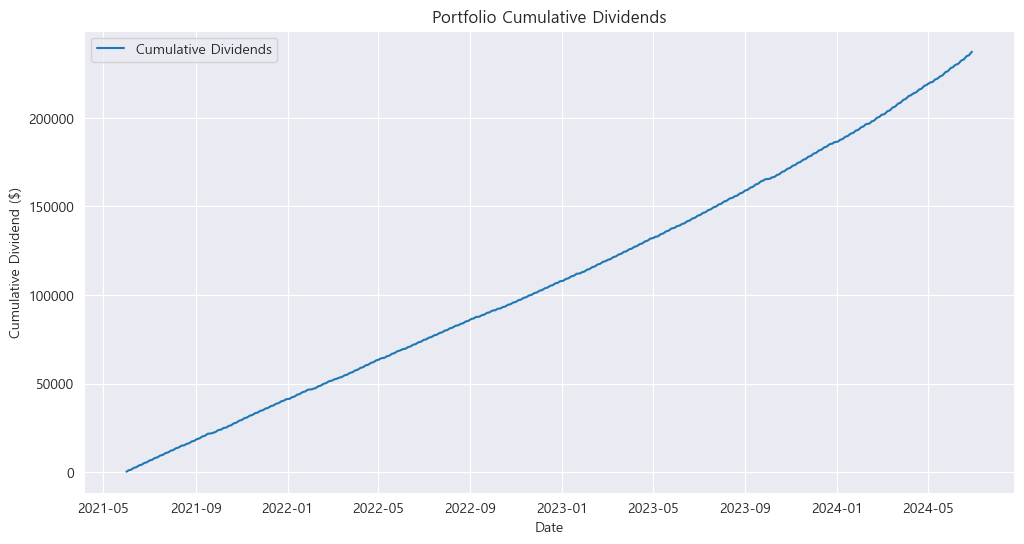

In [13]:
from matplotlib import font_manager, rc
# 한글 폰트 설정 (예: 나눔고딕)
font_path = "C:/Windows/Fonts/malgun.ttf"  # Windows 환경에서 '맑은 고딕' 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 종목코드, 회사명, 배당률 데이터 정의
dividend_info = [
    {"ticker": "267250.ks", "name": "HD현대", "dividend_yield": 8},
    {"ticker": "018670.ks", "name": "SK가스", "dividend_yield": 5},
    {"ticker": "005830.ks", "name": "DB손해보험", "dividend_yield": 6.4},
    {"ticker": "000810.ks", "name": "삼성화재", "dividend_yield": 6.08},
    {"ticker": "000270.ks", "name": "기아", "dividend_yield": 4.9},
    {"ticker": "000660.ks", "name": "SK하이닉스", "dividend_yield": 1},
    {"ticker": "036460.ks", "name": "한국가스공사", "dividend_yield": 2.3},
    {"ticker": "005930.ks", "name": "삼성전자", "dividend_yield": 2},
    {"ticker": "105560.ks", "name": "KB금융", "dividend_yield": 5.6},
    {"ticker": "373220.ks", "name": "LG에너지솔루션", "dividend_yield": 0}
]

# 배당률을 사용하여 배당금 데이터프레임 생성
dividend_data = pd.DataFrame()
for data in dividend_info:
    ticker = data['ticker']
    dividend_yield = data['dividend_yield'] / 100  # 배당률을 백분율로 변환
    try:
        stock_data = yf.download(ticker, start="2021-06-01", end="2024-06-30", progress=False)
        dividends = stock_data['Adj Close'] * dividend_yield / 12  # 월별 배당금 계산
        dividend_data[ticker] = dividends
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

# 결측치 처리
dividend_data = dividend_data.fillna(0)

# 포트폴리오 배당금 계산 (recommended_portfolio['weight']를 사용한다고 가정)
recommended_portfolio = pd.DataFrame({
    'ticker': [data['ticker'] for data in dividend_info],
    'weight': [1/len(dividend_info)] * len(dividend_info)  # 동일 가중치 사용
})
recommended_portfolio.set_index('ticker', inplace=True)

portfolio_dividends = dividend_data * recommended_portfolio['weight']
portfolio_dividends['Total_Dividend'] = portfolio_dividends.sum(axis=1)

# 누적 배당금 계산
cumulative_dividends = portfolio_dividends['Total_Dividend'].cumsum()

# 배당금 시각화
plt.figure(figsize=(12, 6))
plt.plot(cumulative_dividends, label='Cumulative Dividends')
plt.title('Portfolio Cumulative Dividends')
plt.xlabel('Date')
plt.ylabel('Cumulative Dividend ($)')
plt.legend()
plt.show()

Portfolio Volatility (Annualized): 6.25%
Maximum Drawdown: -22.37%
Value at Risk (95%): -0.59%


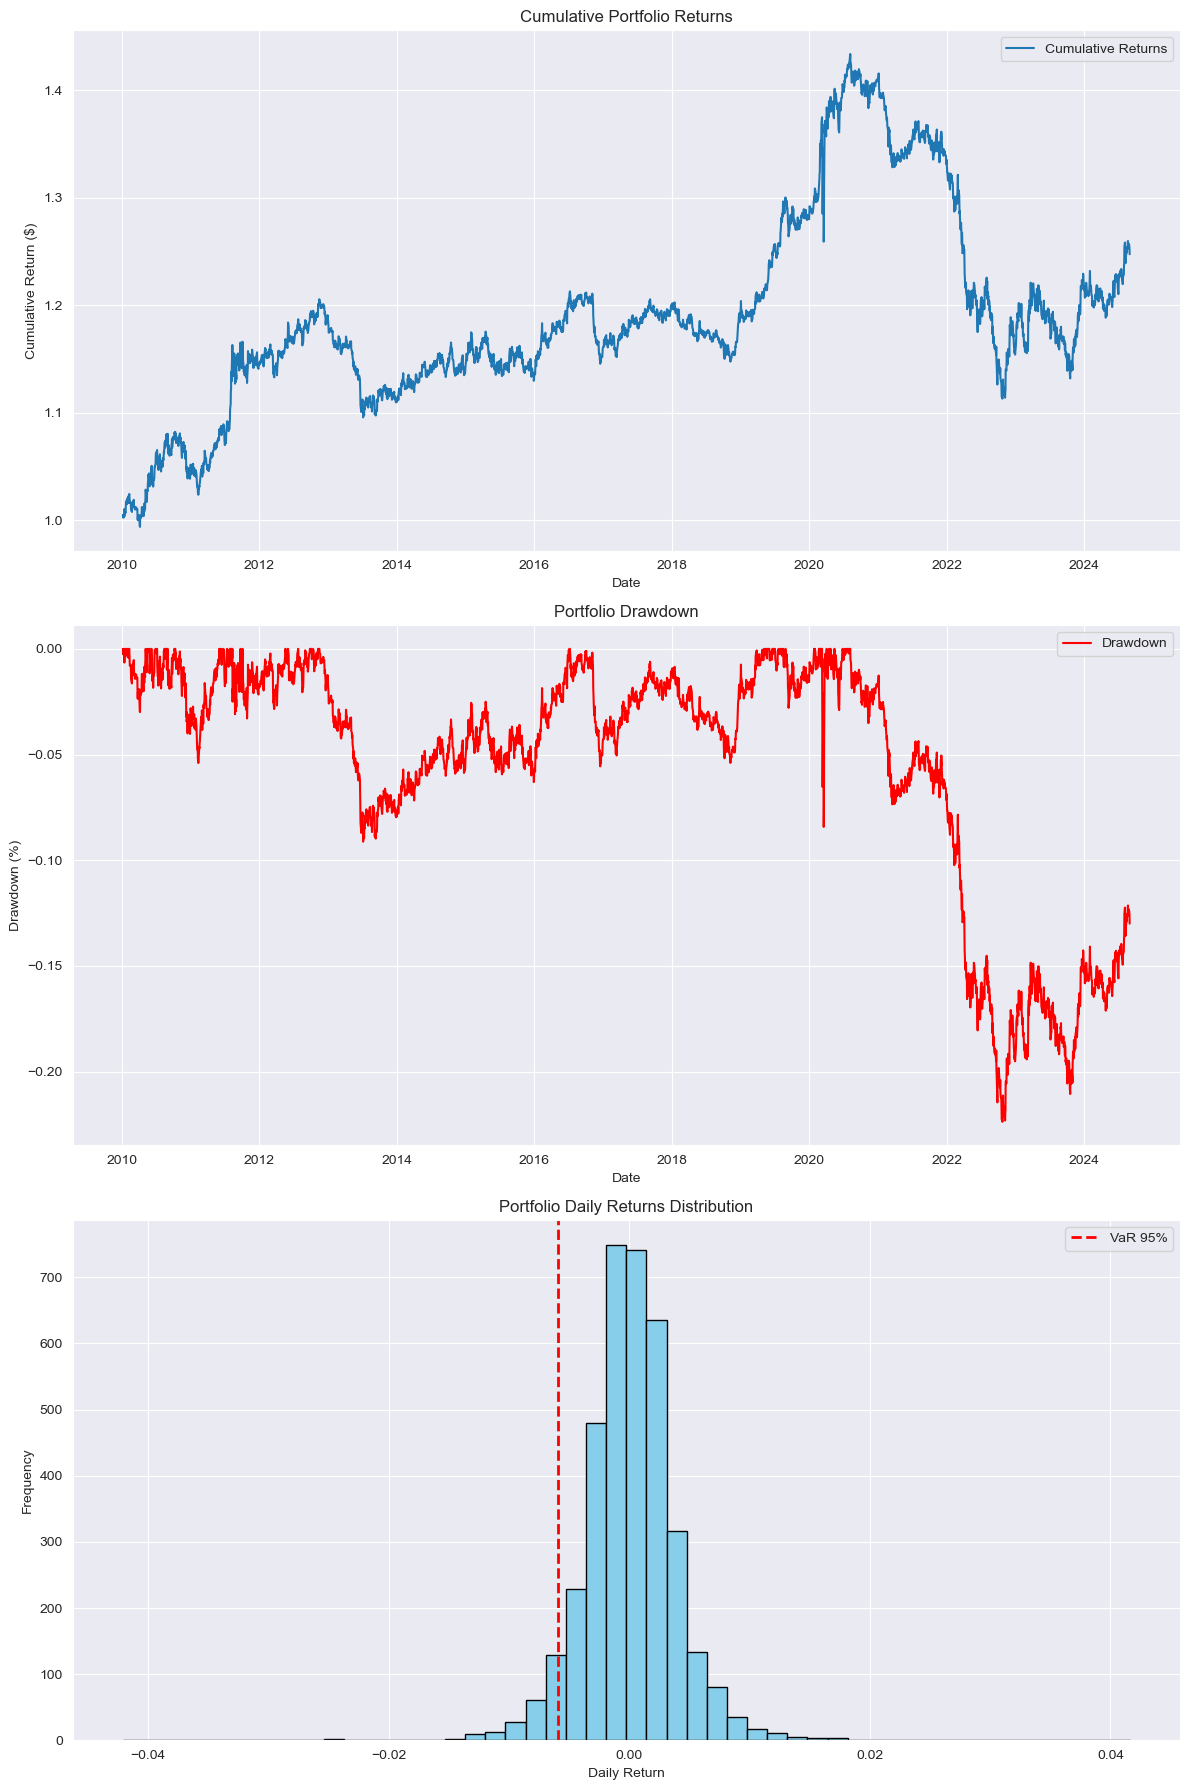

In [22]:
import matplotlib.dates as mdates

# 포트폴리오의 일간 수익률 계산
portfolio_daily_returns = (returns * recommended_portfolio['weight']).sum(axis=1)

# 누적 수익률 계산
cumulative_portfolio_returns = (1 + portfolio_daily_returns).cumprod()

# 변동성 계산 (일간 수익률의 표준편차)
portfolio_volatility = portfolio_daily_returns.std() * np.sqrt(252)  # 연간 변동성

# 최대 낙폭 계산
rolling_max = cumulative_portfolio_returns.cummax()
drawdown = (cumulative_portfolio_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# Value at Risk (VaR) 계산 (95% 신뢰 수준)
VaR_95 = portfolio_daily_returns.quantile(0.05)

# 리스크 지표 출력
print(f"Portfolio Volatility (Annualized): {portfolio_volatility:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Value at Risk (95%): {VaR_95:.2%}")

# 리스크 지표 시각화
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# 변동성 시각화
ax[0].plot(cumulative_portfolio_returns, label='Cumulative Returns')
ax[0].set_title('Cumulative Portfolio Returns')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Cumulative Return ($)')
ax[0].legend()
ax[0].grid(True)

# 최대 낙폭 시각화
ax[1].plot(drawdown, color='red', label='Drawdown')
ax[1].set_title('Portfolio Drawdown')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Drawdown (%)')
ax[1].legend()
ax[1].grid(True)

# VaR 시각화
ax[2].hist(portfolio_daily_returns, bins=50, color='skyblue', edgecolor='k')
ax[2].axvline(VaR_95, color='red', linestyle='dashed', linewidth=2, label='VaR 95%')
ax[2].set_title('Portfolio Daily Returns Distribution')
ax[2].set_xlabel('Daily Return')
ax[2].set_ylabel('Frequency')
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()


In [23]:
# 리스크 기준 설정
max_allowed_volatility = 0.15  # 연간 변동성 15%
max_allowed_drawdown = -0.20   # 최대 낙폭 20%
VaR_threshold = -0.05          # VaR 95% -5%

# 리스크 지표 확인
if (portfolio_volatility > max_allowed_volatility) or (max_drawdown < max_allowed_drawdown):
    print("리스크 기준 초과: 포트폴리오 조정 필요")
    # 안정적인 자산 비중 증가, 위험 자산 비중 감소
    # 예시: 위험 자산의 가중치를 10% 감소하고, 안정 자산의 가중치를 10% 증가
    # 실제로는 더 정교한 조정이 필요합니다.
    risk_assets = ['SPY', 'XLV', 'IYR']  # 예시로 위험 자산 선정
    safe_assets = ['AGG', 'GLD', 'XLU', 'TLT', 'TIP', 'BND', 'LQD']  # 안전 자산

    # 위험 자산 가중치 감소
    for asset in risk_assets:
        recommended_portfolio.loc[asset, 'weight'] *= 0.90

    # 안전 자산 가중치 증가
    for asset in safe_assets:
        recommended_portfolio.loc[asset, 'weight'] *= 1.10

    # 가중치 재정규화
    recommended_portfolio['weight'] = recommended_portfolio['weight'] / recommended_portfolio['weight'].sum()

    print("포트폴리오 가중치 조정 완료:")
    print(recommended_portfolio.sort_values('weight', ascending=False))
else:
    print("리스크 기준 내: 포트폴리오 유지")


리스크 기준 초과: 포트폴리오 조정 필요
포트폴리오 가중치 조정 완료:
        predicted_return  volatility    weight
Ticker                                        
AGG            -0.023593    0.002988  0.417353
BND            -0.020415    0.003050  0.353765
TIP            -0.012058    0.003675  0.173387
LQD            -0.010234    0.004873  0.110996
GLD            -0.007999    0.009765  0.043292
TLT            -0.007165    0.009647  0.039249
SPY            -0.000675    0.010796  0.002704
XLV             0.002075    0.010195 -0.008800
XLU             0.010948    0.011101 -0.052119
IYR             0.023532    0.012746 -0.079829


C:\Users\rkddk\AppData\Local\Temp\ipykernel_32492\3604435448.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_portfolio['weight'] = recommended_portfolio['weight'] / recommended_portfolio['weight'].sum()
